# Learning Rate, Batch Size, FashionMNIST

This notebook explores the cyclical learning rate policy and its effect on training a neural network. It also compares the effect of varying batch sizes with a fixed learning rate.

## Overview
The key steps involve identifying optimal learning rates, implementing the cyclical learning rate policy, and comparing the effects of batch size and learning rate on model performance.

## Procedure
- **Optimal Learning Rates**: Identify \( \text{lrmin} \) and \( \text{lrmax} \) by plotting training loss for different learning rates.
- **Cyclical Learning Rate**: Implement the cyclical learning rate policy and train the network, plotting train/validation loss and accuracy.
- **Batch Size Experiment**: Train the network with varying batch sizes and compare the generalization performance with the cyclical learning rate policy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import warnings
warnings.filterwarnings("ignore")



#### Configure device for GPU


In [2]:
%env PYTORCH_ENABLE_MPS_FALLBACK=0

dtype = torch.float
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
torch.set_default_device('mps' if torch.backends.mps.is_available() else 'cpu')
gpu_options = {'pin_memory': True, 'num_workers': 4, 'persistent_workers': True, 'prefetch_factor': 8}

mod = torch.nn.Linear(20, 30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)


env: PYTORCH_ENABLE_MPS_FALLBACK=0
mps:0
mps:0


### Problem 5 - Part 1


In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),

])

train_dataset_raw = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_raw = FashionMNIST(root='./data', train=False, download=True, transform=transform)



train_loader = DataLoader(train_dataset_raw, batch_size=64, shuffle=True, **gpu_options)
test_loader = DataLoader(test_dataset_raw, batch_size=64, shuffle=True, **gpu_options)

train_loader


In [4]:

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, device=device, dtype=dtype)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, device=device, dtype=dtype)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, device=device, dtype=dtype)
        self.fc2 = nn.Linear(120, 84, device=device, dtype=dtype)
        self.fc3 = nn.Linear(84, 10, device=device, dtype=dtype)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

LeNet5().to(device)


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
# Test one training cycle

batch_size = 64
train_loader = DataLoader(train_dataset_raw, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset_raw, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=False)

# train_loader.dataset.dataset.tensors[0].device
lr_grid = [10**(-i) for i in range(9, -2, -1)]
lr_grid = np.logspace(-9, 1, num=11)
lr_grid


array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01])

In [6]:
from tqdm import tqdm
gpu_options = {'pin_memory': True, 'num_workers': 4, 'persistent_workers': True, 'prefetch_factor': 1200}

batch_size = 64
train_loader = DataLoader(train_dataset_raw, batch_size=batch_size, **gpu_options)
test_loader = DataLoader(test_dataset_raw, batch_size=batch_size ,  **gpu_options)


In [7]:
g = enumerate(train_loader)
d = enumerate(test_loader)


In [19]:
from tqdm import tqdm

gpu_options = {'pin_memory': True, 'num_workers': 4, 'persistent_workers': True, 'prefetch_factor': 1200}

batch_size = 64
train_loader = DataLoader(train_dataset_raw, batch_size=batch_size, **gpu_options)
test_loader = DataLoader(test_dataset_raw, batch_size=batch_size, **gpu_options)

lr_grid = np.logspace(-9, 1, num=10)
epochs = 5

losses = []
for lr in lr_grid:

    model = LeNet5()
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    tmp_losses = []
    for epoch in range(epochs):
        loop = tqdm(train_loader, total=len(train_loader), leave=True)
        for batch, (inputs, labels) in enumerate(loop):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            tmp_losses.append(loss.item())

            loop.set_description(f"Epoch: {epoch}")
            loop.set_postfix(loss=loss.item())
            loop.update()
    losses.append(tmp_losses)


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 4: 100%|██████████| 938/938 [00:08<00:00, 116.22it/s, loss=2.47]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.1622776601683795e-10 31.622776601683793


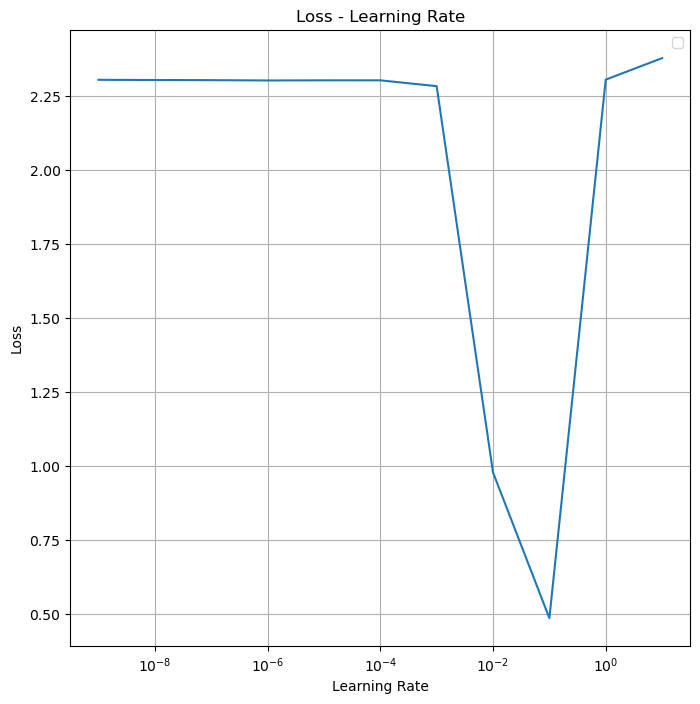

Min idx: 8, Max idx: 10
Min: 0.1, Max: 10.0


In [31]:
import matplotlib as mpl
import seaborn as sns

mpl.RcParams['']
loss = [losses[i][-1] for i in range(len(losses))]

plt.figure(figsize=(8, 8))
sns.lineplot(x=lr_grid, y=np.mean(losses, axis=1))
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title("Loss - Learning Rate")
plt.legend()
plt.grid()

left, right = plt.xlim()
print(left, right)
plt.show()
av_losses = np.mean(losses, axis=1)
lr_min = np.argmin(av_losses)
lr_max = np.argmax(av_losses)


print(f"Min idx: {lr_min}, Max idx: {lr_max}")
print(f"Min: {lr_grid[lr_min]}, Max: {lr_grid[lr_max]}")


In [45]:
av_losses
lr_min = lr_grid[np.argmin(loss)]
lr_max = lr_grid[np.argmax(np.gradient(loss))]


lr_min, lr_max


(0.1, 1.0)

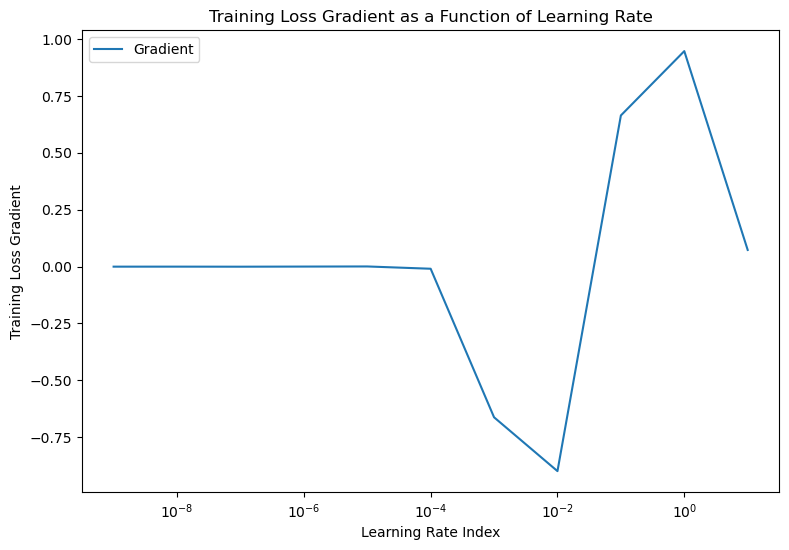

lr_min: 0.1, lr_max: 1.0


In [48]:
plt.figure(figsize=(9, 6))
plt.title('Training Loss Gradient as a Function of Learning Rate')
plt.plot(lr_grid, np.gradient(av_losses), label='Gradient')
plt.xscale('log')
plt.xlabel('Learning Rate Index')
plt.ylabel('Training Loss Gradient')
plt.legend()
plt.show()

lr_min = lr_grid[np.argmin(loss)]
lr_max = lr_grid[np.argmax(np.gradient(loss))]


print(f"lr_min: {lr_min}, lr_max: {lr_max}")


- From the plot above, we can see that from $10^{-9}$ to $10^{-4}$, the loss remains relatively constant. Then the loss starts to decrease, bottoming out at $10^{-2}$. After that, the loss rapidly increases, peaking at around $10^{0}$. Therefore, we can set `lr_min` to $10^{-4}$ and `lr_max` to $10^{-1}$.

In [114]:
learning_rates = np.logspace(-9, 1, num=11)
av_losses = np.mean(losses, axis=1)
lr_min = lr_grid[np.argmin(av_losses[:-1])]
lr_max = lr_grid[np.argmax(np.gradient(av_losses[:-1]))]

print(f"Min: {lr_min}, Max: {lr_max}")


Min: 0.1, Max: 1


### Problem 5 - Part 2
 Use the cyclical learning rate policy (with exponential decay) and train your network using batch size
 64 and lrmin and lrmax values obtained in part 1. Plot train/validation loss and accuracy curve over
the number of epochs

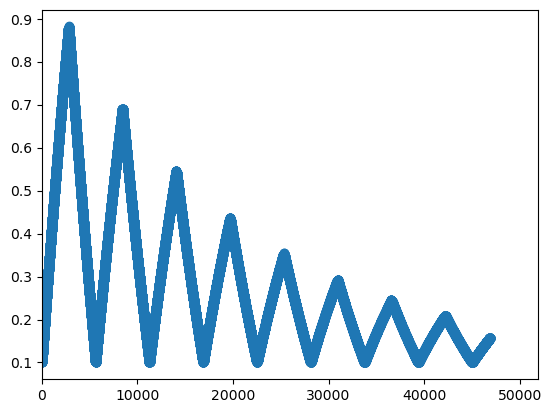

In [99]:
def cyclical_learning_rate(batch_step,
                           step_size,
                           base_lr=0.1,
                           max_lr=1.0,
                           gamma=0.999995):

    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)
    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    lr_delta = lr_delta * (gamma**(batch_step))
    lr = base_lr + lr_delta

    return lr



lr_min, lr_max = (0.1, 1.0)
batch_size = 64
epochs = 50

stepsize = int(len(train_loader) * 3)

train_loader = DataLoader(train_dataset_raw, batch_size=batch_size, **gpu_options)
test_loader = DataLoader(test_dataset_raw, batch_size=batch_size,   **gpu_options)

iter_per_ep = len(train_loader)


batch_step = -1
collect_lr = []
for e in range(epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=iter_per_ep*3,
                                        base_lr=lr_min,
                                        max_lr=lr_max,
                                        gamma=0.99995)

        collect_lr.append(cur_lr)

plt.scatter(range(len(collect_lr)), collect_lr)
# plt.ylim([0.0, 0.01])
plt.xlim([0, epochs*iter_per_ep + 5000])
plt.show()


In [29]:

def cyclical_learning_rate(batch_step,
                           step_size,
                           base_lr=0.1,
                           max_lr=1.0,
                           gamma=0.995):

    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)
    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    lr_delta = lr_delta * (gamma**(batch_step))
    lr = base_lr + lr_delta

    return lr

def cyclical_learning_rate(batch_step,
                           step_size,
                           base_lr=0.1,
                           max_lr=1.0,
                           gamma=0.999995):

    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)
    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    lr_delta = lr_delta * (gamma**(batch_step))
    lr = base_lr + lr_delta

    return lr


def cyclical_learning_rate(batch_step, step_size, base_lr=0.1, max_lr=1.0, gamma=0.995):
    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / step_size - 2 * cycle + 1)
    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    lr = base_lr + lr_delta * (gamma ** batch_step)
    return lr



In [11]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

random_seed = 52
lr_min, lr_max = 0.01, 1.0
batch_size = 64
epochs = 25

train_loader = DataLoader(train_dataset_raw, batch_size=batch_size, **gpu_options)
test_loader = DataLoader(test_dataset_raw, batch_size=batch_size, **gpu_options)

model = LeNet5().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr_min)
criterion = nn.CrossEntropyLoss()

lrs = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

batch_step = -1
lr = lr_min

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    with tqdm(train_loader, total=len(train_loader)) as loop:
        for batch, (inputs, labels) in enumerate(train_loader):
            loop.set_description(f"Epoch: {epoch+1}/{epochs}")
            batch_step += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            loop.set_postfix(learning_rate=lr, Train_Acc=correct / total, Train_Loss=running_loss / len(train_loader), refresh=True)
            loop.update()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(test_loader))
        val_acc.append(correct / total)

        lrs.append(lr)
        lr = cyclical_learning_rate(batch_step, len(train_loader) * 5, lr_min, lr_max, gamma=0.999)

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        loop.set_postfix_str(f"Learning Rate: {lr:>6.3f}, Train_Loss: {train_losses[-1]:>6.3f}, Train_Acc: {train_acc[-1]:>6.3f}, Val_Loss: {val_losses[-1]:>6.3f}, Val_Acc: {val_acc[-1]:>6.3f}")


Epoch: 25/25: 100%|██████████| 938/938 [00:10<00:00, 89.81it/s, Learning Rate:  0.010, Train_Loss:  0.234, Train_Acc:  0.915, Val_Loss:  0.303, Val_Acc:  0.895] 


In [10]:
def cyclical_learning_rate(batch_step,
                           step_size,
                           base_lr=0.1,
                           max_lr=1.0,
                           gamma=0.995):

    cycle = np.floor(1 + batch_step / ( step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)
    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    lr_delta = lr_delta * (gamma**(batch_step))
    lr = base_lr + lr_delta

    return lr

def cyclical_learning_rate(batch_step, step_size,
                base_lr=10e-4, max_lr=10e-1, gamma=0.9999):

    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)
    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    lr_delta = lr_delta * (gamma**(batch_step))
    lr = base_lr + lr_delta
    print(f'cycle: {cycle}, x: {x}, lr_delta: {lr_delta}, base_lr: {base_lr}, lr: {lr}\n')
    return lr



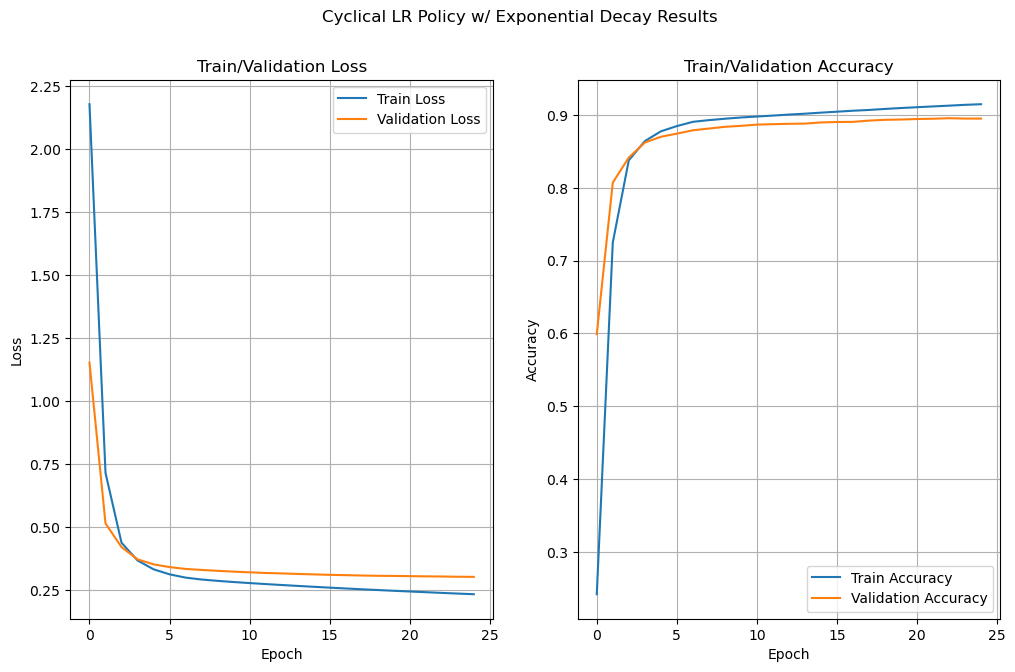

In [17]:
plt.figure(figsize=(12, 7))
plt.subplot(121)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Train/Validation Loss')


plt.subplot(122)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Train/Validation Accuracy')

plt.suptitle('Cyclical LR Policy w/ Exponential Decay Results')
plt.show()




### Question 5 Part 3


In [31]:
device = torch.device('cpu')


In [60]:
torch.set_default_device('mps')
device = torch.device('mps')

batch_sizes = [2**i for i in range(5, 13)]

lr_max = 1e-1
epochs = 5
batch_step = -1

random_seed = 52
lr_min, lr_max = 0.01, 1.0
batch_size = 64
epochs = 25
lr = lr_max

batch_sizes = [2**i for i in range(5, 13)]

lr_max = 1e-1
epochs = 5

train_losses = []
lrs = []
batch_losses_m1 = []

train_losses = []
lrs = []
train_acc = []
val_losses = []
val_acc = []
losses = []
# epochs = 2

for batch_size in batch_sizes:

    model = LeNet5().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr_max)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset_raw, batch_size=batch_size, **gpu_options)
    test_loader = DataLoader(test_dataset_raw, batch_size=batch_size,   **gpu_options)
    losses_tmp = []
    losses_batch_tmp = []

    for epoch in range(epochs):
        # loop = tqdm(train_loader, total=len(train_loader))
        model.train()
        correct = 0
        total = 0
        running_loss = 0
        train_loss = 0

        # with tqdtrain_loader, total=len(train_loader)) as loop:
        for batch, (inputs, labels) in enumerate(train_loader):
            # loop.set_description(f"Epoch: {epoch+1}/{epochs}")
            batch_step += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            losses_tmp.append(loss.item())


        train_losses.append(running_loss / len(train_loader))
        losses_batch_tmp.append(running_loss / len(train_loader))
        train_acc.append(correct / total)


        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(test_loader))
        val_acc.append(correct / total)

        print(f"Batch Size: {batch_size:.3f}, Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_acc[-1]:.3f}")
    losses.append(losses_tmp)
    batch_losses_m1.append(losses_batch_tmp)



Batch Size: 32.000, Train Loss: 0.690, Train Acc: 0.736, Val Loss: 0.468, Val Acc: 0.830
Batch Size: 32.000, Train Loss: 0.396, Train Acc: 0.854, Val Loss: 0.380, Val Acc: 0.859
Batch Size: 32.000, Train Loss: 0.337, Train Acc: 0.876, Val Loss: 0.342, Val Acc: 0.874
Batch Size: 32.000, Train Loss: 0.302, Train Acc: 0.887, Val Loss: 0.335, Val Acc: 0.876
Batch Size: 32.000, Train Loss: 0.280, Train Acc: 0.895, Val Loss: 0.321, Val Acc: 0.887
Batch Size: 64.000, Train Loss: 1.029, Train Acc: 0.613, Val Loss: 0.555, Val Acc: 0.780
Batch Size: 64.000, Train Loss: 0.444, Train Acc: 0.835, Val Loss: 0.462, Val Acc: 0.826
Batch Size: 64.000, Train Loss: 0.374, Train Acc: 0.862, Val Loss: 0.415, Val Acc: 0.847
Batch Size: 64.000, Train Loss: 0.338, Train Acc: 0.874, Val Loss: 0.401, Val Acc: 0.852
Batch Size: 64.000, Train Loss: 0.314, Train Acc: 0.882, Val Loss: 0.367, Val Acc: 0.867
Batch Size: 128.000, Train Loss: 1.284, Train Acc: 0.530, Val Loss: 0.617, Val Acc: 0.755
Batch Size: 128.000,

In [52]:
torch.set_default_device('cpu')
device = torch.device('cpu')


dataloaders = [DataLoader(train_dataset_raw, batch_size=2**i, shuffle=True) for i in range(5, 13)]

model = LeNet5().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr_max)
criterion = nn.CrossEntropyLoss()
batch_losses_m2 = []
all_losses = []
epochs = len(dataloaders)


for epoch in range(epochs):
    # Switch DataLoader every epoch
    train_loader = dataloaders[epoch % len(dataloaders)]
    running_loss = 0
    for batch, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        all_losses.append(loss.item())
    batch_losses_m2.append(running_loss / len(train_loader))
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {batch_losses_m2[-1]:.3f}")




Epoch: 1/8, Loss: 0.706
Epoch: 2/8, Loss: 0.396
Epoch: 3/8, Loss: 0.340
Epoch: 4/8, Loss: 0.312
Epoch: 5/8, Loss: 0.299
Epoch: 6/8, Loss: 0.291
Epoch: 7/8, Loss: 0.285
Epoch: 8/8, Loss: 0.284


### Remark

I didn't fully understand how to implement the given the question. Therefore I tried two implementations.

- First Configuration: This trains an independent model for each batch size. 
- Second Configuration: This trains a single model, with an iterative batch size at each epoch.


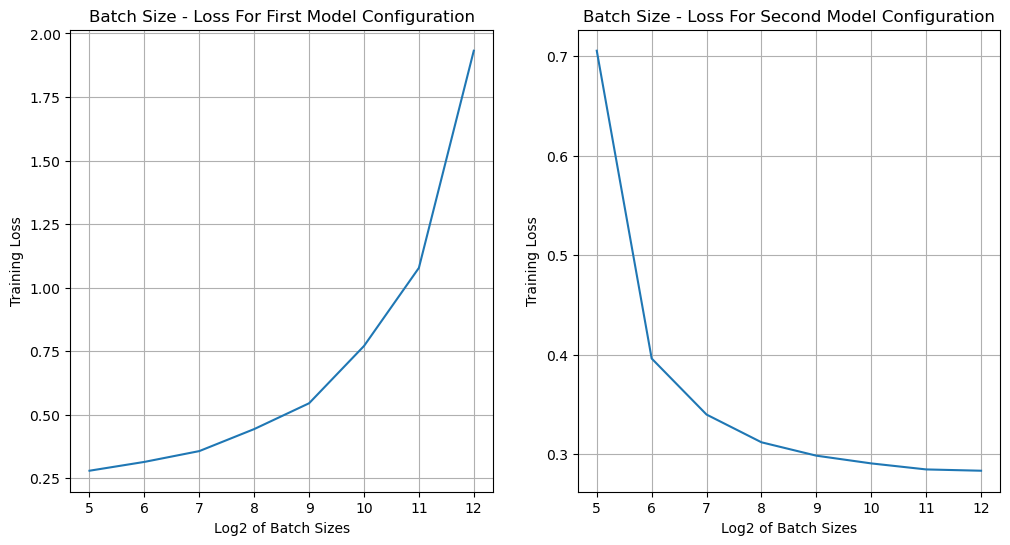

In [73]:
train_losses_epoch = [loss[-1] for loss in  losses ]

# plt.plot(np.log2(batch_sizes), train_losses_epoch)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(np.log2(batch_sizes), [loss[-1] for loss in batch_losses_m1])
plt.grid()
plt.xlabel('Log2 of Batch Sizes')
plt.ylabel('Training Loss')
plt.title('Batch Size - Loss For First Model Configuration')

plt.subplot(122)


plt.plot(np.log2(batch_sizes), [loss for loss in batch_losses_m2])

plt.grid()
plt.xlabel('Log2 of Batch Sizes')
plt.ylabel('Training Loss')
plt.title('Batch Size - Loss For Second Model Configuration')
plt.show()



From the figures we can see that:

- For the first model config, which trains an independent model per batch size, we can see that training loss per log2 of batch size grows at an exponential rate. 

- For the second model config, which iterates upon batch size per each epoch, we can see that the training loss per log2 of batch size grows at an exponentially decreasing rate. 
  
I believe the first model config is the correct implementation. However, both implementations are included in the notebook.
